# 时间序列预测ARIMA模型 - 案例一：股票价格预测
# Mathematical Modeling Course - Case Study 1: Stock Price Forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 统计分析库
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

# 机器学习库
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 设置中文显示和图形样式
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
print("=" * 60)
print("         时间序列预测ARIMA模型 - 股票价格预测案例")
print("=" * 60)

         时间序列预测ARIMA模型 - 股票价格预测案例


# ==========================================
# 第一步：数据生成与加载
# ==========================================

In [3]:
def generate_stock_data(start_date='2023-01-01', periods=180, initial_price=100):
    """
    生成模拟股票价格数据
    包含趋势、波动率和随机游走特征
    """
    np.random.seed(42)  # 保证结果可重复
    
    # 创建日期索引
    dates = pd.date_range(start=start_date, periods=periods, freq='D')
    
    # 生成价格序列：随机游走 + 微弱趋势 + 波动率变化
    returns = np.random.normal(0.001, 0.02, periods)  # 日收益率
    trend = np.linspace(0, 0.5, periods) / periods    # 微弱上升趋势
    volatility = 1 + 0.3 * np.sin(np.linspace(0, 4*np.pi, periods))  # 波动率周期性变化
    
    returns = returns + trend
    returns = returns * volatility
    
    # 计算累积价格
    prices = [initial_price]
    for r in returns[1:]:
        prices.append(prices[-1] * (1 + r))
    
    # 创建DataFrame
    df = pd.DataFrame({
        'date': dates,
        'price': prices,
        'returns': [0] + list(np.diff(np.log(prices)))  # 对数收益率
    })
    df.set_index('date', inplace=True)
    
    return df

# 生成数据
print("\n1. 数据生成与加载")
print("-" * 30)
stock_data = generate_stock_data()
print(f"数据期间: {stock_data.index[0].strftime('%Y-%m-%d')} 至 {stock_data.index[-1].strftime('%Y-%m-%d')}")
print(f"数据点数: {len(stock_data)}")
print(f"价格范围: {stock_data['price'].min():.2f} - {stock_data['price'].max():.2f}")

# 显示基本统计信息
print("\n数据基本统计:")
print(stock_data.describe())


1. 数据生成与加载
------------------------------
数据期间: 2023-01-01 至 2023-06-29
数据点数: 180
价格范围: 79.68 - 124.24

数据基本统计:
            price     returns
count  180.000000  180.000000
mean    94.027824    0.001206
std      9.645286    0.019637
min     79.677459   -0.047381
25%     85.858881   -0.010224
50%     91.163871    0.002776
75%    100.535099    0.012523
max    124.242341    0.065390


# ==========================================
# 第二步：数据探索与可视化
# ==========================================


2. 数据探索与可视化
------------------------------


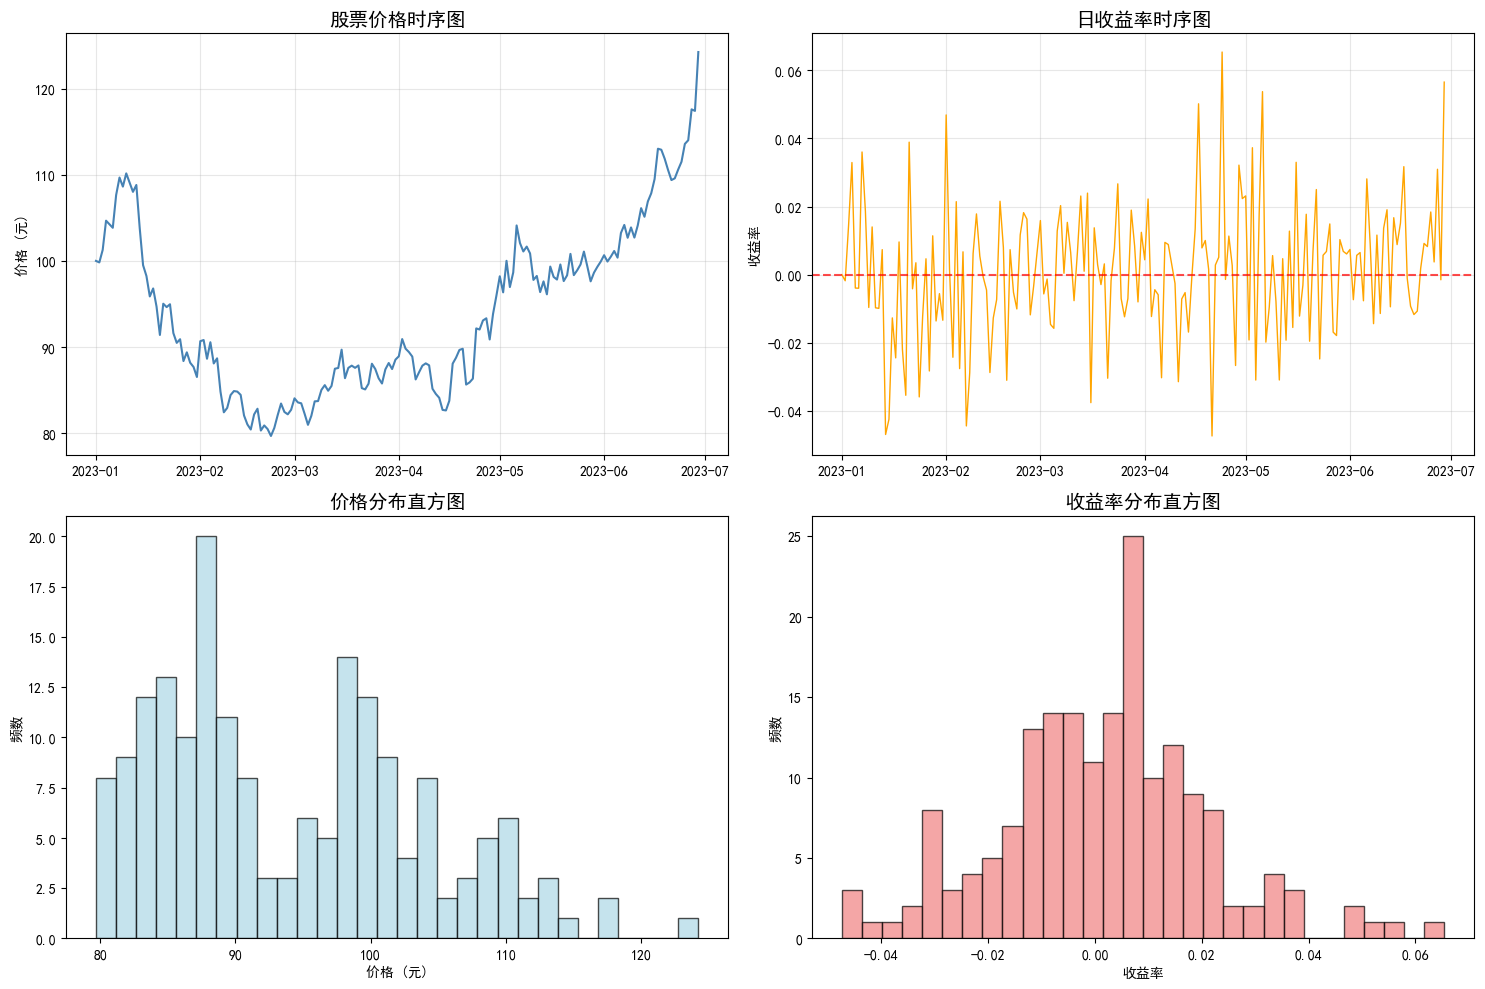

年化波动率: 31.17%
最大回撤: -27.67%
收益率偏度: 0.169
收益率峰度: 0.694


In [4]:
print("\n2. 数据探索与可视化")
print("-" * 30)

# 创建综合图表
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 价格时序图
axes[0,0].plot(stock_data.index, stock_data['price'], color='steelblue', linewidth=1.5)
axes[0,0].set_title('股票价格时序图', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('价格 (元)')
axes[0,0].grid(True, alpha=0.3)

# 收益率时序图
axes[0,1].plot(stock_data.index, stock_data['returns'], color='orange', linewidth=1)
axes[0,1].axhline(y=0, color='red', linestyle='--', alpha=0.7)
axes[0,1].set_title('日收益率时序图', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('收益率')
axes[0,1].grid(True, alpha=0.3)

# 价格分布直方图
axes[1,0].hist(stock_data['price'], bins=30, color='lightblue', alpha=0.7, edgecolor='black')
axes[1,0].set_title('价格分布直方图', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('价格 (元)')
axes[1,0].set_ylabel('频数')

# 收益率分布直方图
axes[1,1].hist(stock_data['returns'], bins=30, color='lightcoral', alpha=0.7, edgecolor='black')
axes[1,1].set_title('收益率分布直方图', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('收益率')
axes[1,1].set_ylabel('频数')

plt.tight_layout()
plt.show()

# 计算一些描述性统计量
price_volatility = stock_data['returns'].std() * np.sqrt(252)  # 年化波动率
max_drawdown = ((stock_data['price'] / stock_data['price'].cummax()) - 1).min()

print(f"年化波动率: {price_volatility:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")
print(f"收益率偏度: {stock_data['returns'].skew():.3f}")
print(f"收益率峰度: {stock_data['returns'].kurtosis():.3f}")


# ==========================================
# 第三步：平稳性检验
# ==========================================


3. 平稳性检验
------------------------------

原始价格序列 ADF检验结果:
ADF统计量: 0.530361
p值: 0.985767
临界值:
  1%: -3.467
  5%: -2.878
  10%: -2.575
结论: 原始价格序列是非平稳的 (p值 = 0.985767 > 0.05)

收益率序列 ADF检验结果:
ADF统计量: -13.563859
p值: 0.000000
临界值:
  1%: -3.467
  5%: -2.878
  10%: -2.575
结论: 收益率序列是平稳的 (p值 = 0.000000 < 0.05)

价格一阶差分序列 ADF检验结果:
ADF统计量: -13.327625
p值: 0.000000
临界值:
  1%: -3.468
  5%: -2.878
  10%: -2.576
结论: 价格一阶差分序列是平稳的 (p值 = 0.000000 < 0.05)


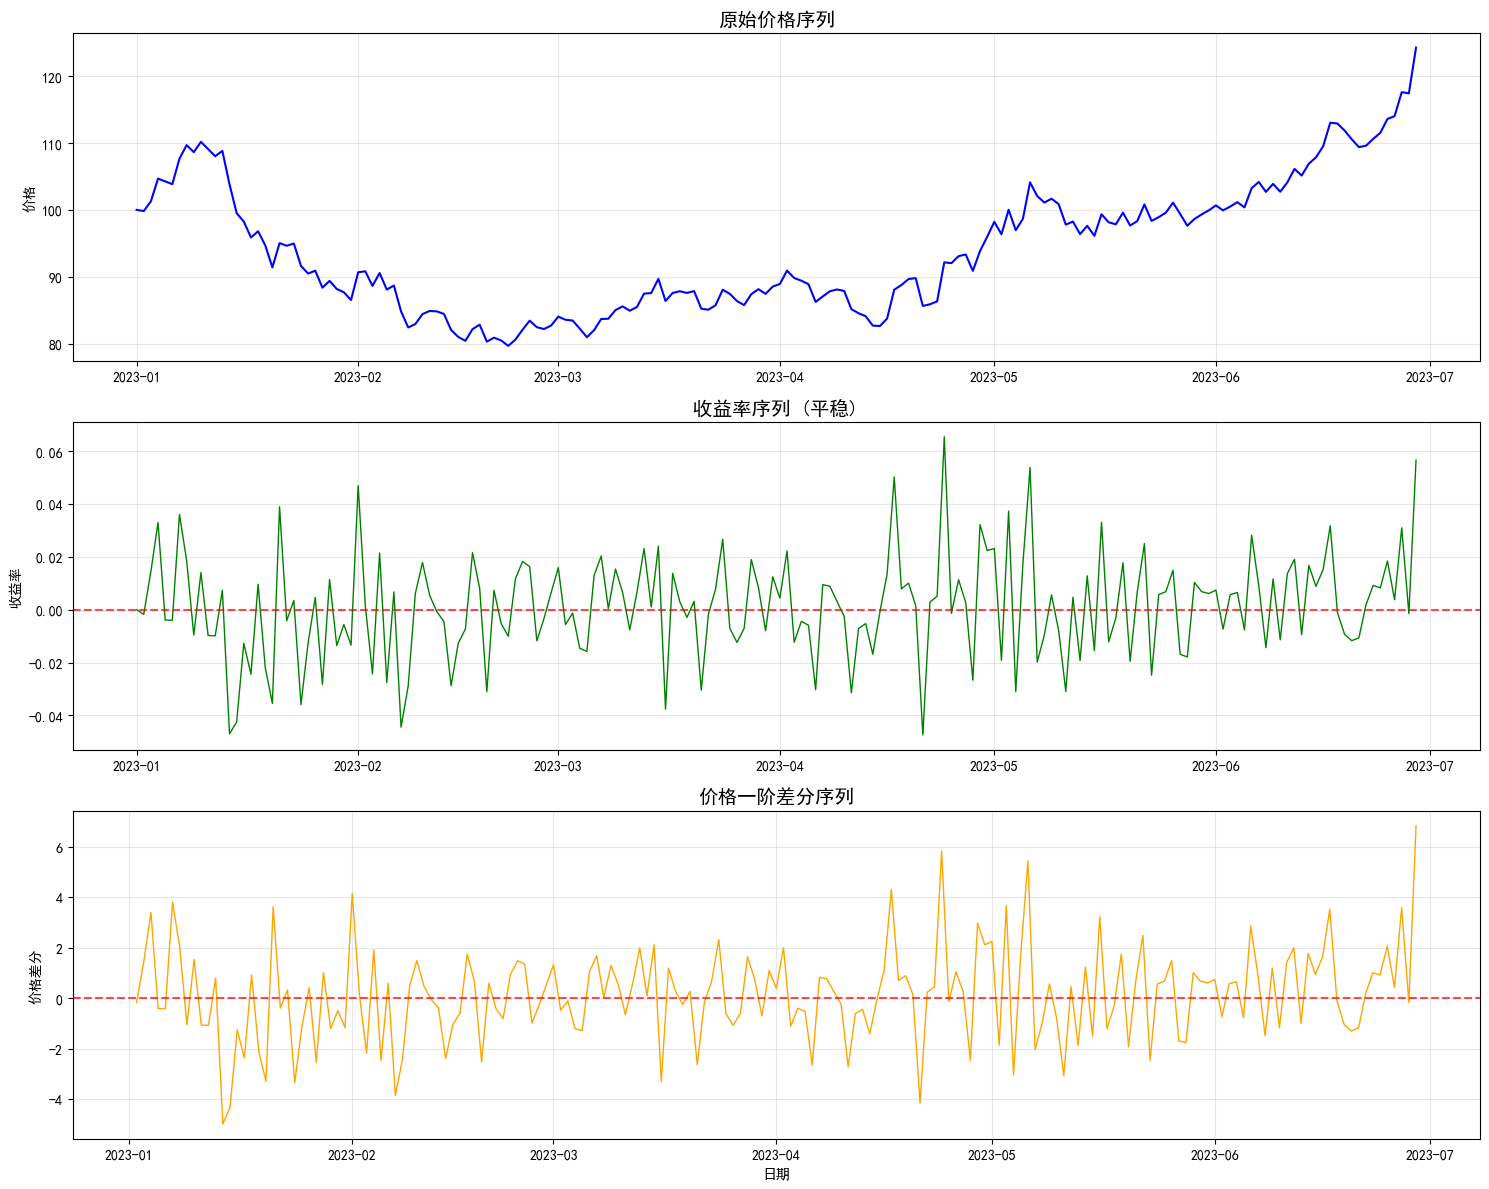

In [5]:
print("\n3. 平稳性检验")
print("-" * 30)

def detailed_adf_test(timeseries, title="时间序列"):
    """
    详细的ADF平稳性检验
    """
    result = adfuller(timeseries.dropna())
    
    print(f'\n{title} ADF检验结果:')
    print(f'ADF统计量: {result[0]:.6f}')
    print(f'p值: {result[1]:.6f}')
    print('临界值:')
    for key, value in result[4].items():
        print(f'  {key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print(f'结论: {title}是平稳的 (p值 = {result[1]:.6f} < 0.05)')
        return True
    else:
        print(f'结论: {title}是非平稳的 (p值 = {result[1]:.6f} > 0.05)')
        return False

# 检验原始价格序列
price_stationary = detailed_adf_test(stock_data['price'], "原始价格序列")

# 检验收益率序列
returns_stationary = detailed_adf_test(stock_data['returns'], "收益率序列")

# 如果价格序列非平稳，进行差分
if not price_stationary:
    stock_data['price_diff'] = stock_data['price'].diff()
    diff_stationary = detailed_adf_test(stock_data['price_diff'], "价格一阶差分序列")

# 可视化平稳性
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# 原始价格
axes[0].plot(stock_data['price'], color='blue', linewidth=1.5)
axes[0].set_title('原始价格序列', fontsize=14, fontweight='bold')
axes[0].set_ylabel('价格')
axes[0].grid(True, alpha=0.3)

# 收益率
axes[1].plot(stock_data['returns'], color='green', linewidth=1)
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.7)
axes[1].set_title('收益率序列 (平稳)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('收益率')
axes[1].grid(True, alpha=0.3)

# 价格差分
axes[2].plot(stock_data['price_diff'], color='orange', linewidth=1)
axes[2].axhline(y=0, color='red', linestyle='--', alpha=0.7)
axes[2].set_title('价格一阶差分序列', fontsize=14, fontweight='bold')
axes[2].set_ylabel('价格差分')
axes[2].set_xlabel('日期')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ==========================================
# 第四步：ACF和PACF分析
# ==========================================


4. ACF和PACF分析
------------------------------


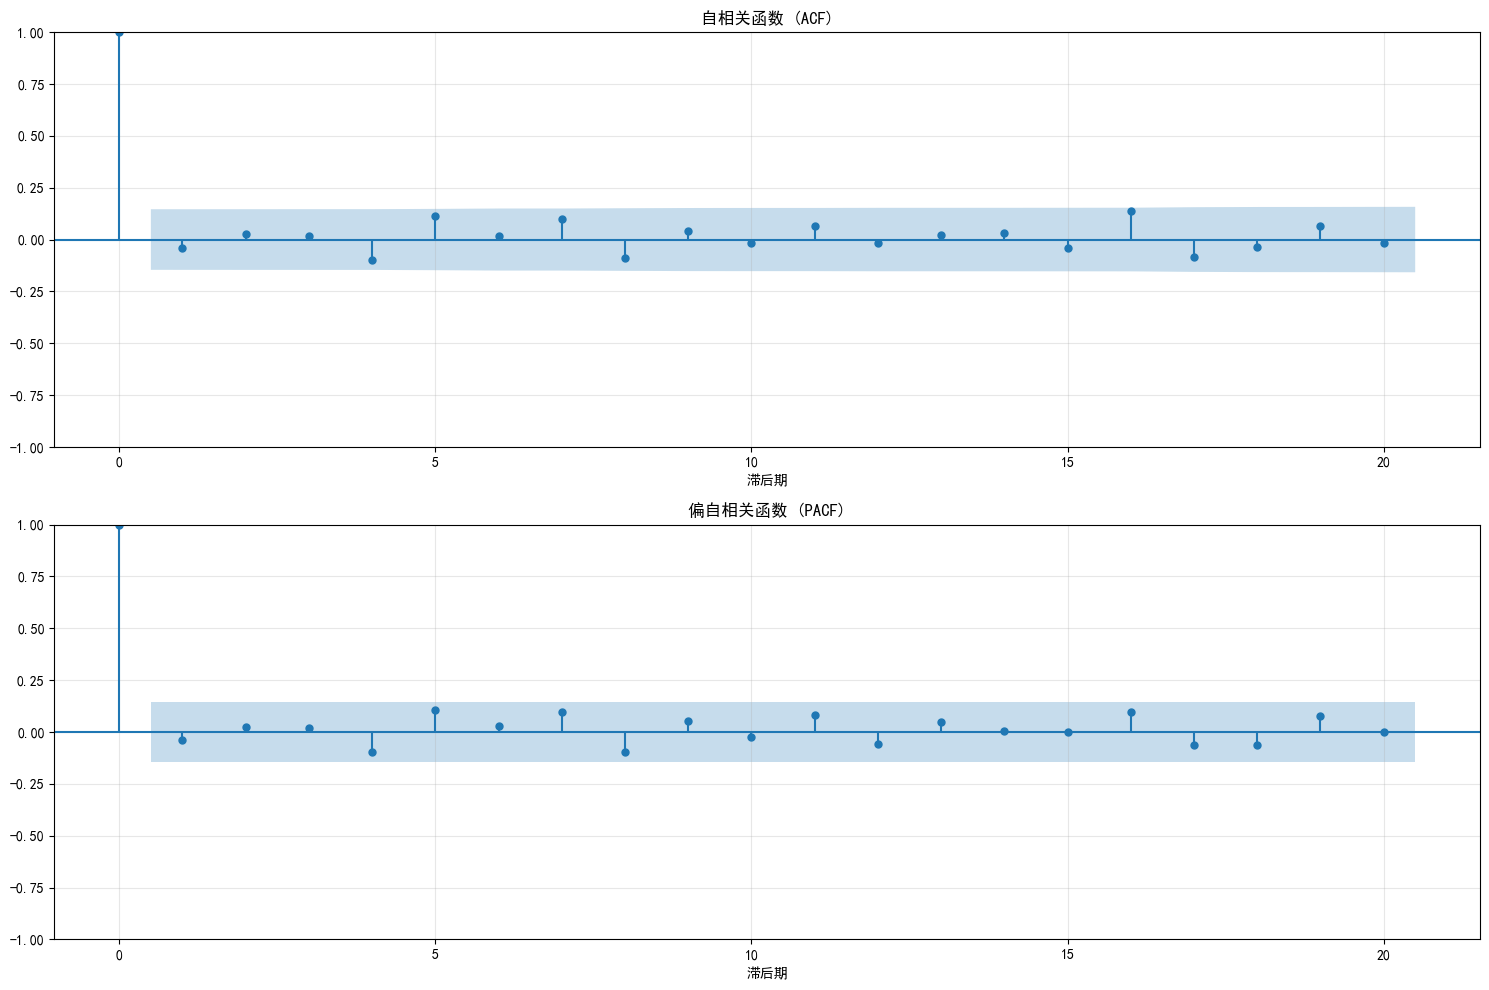

显著的ACF滞后阶数: []
显著的PACF滞后阶数: []
建议的AR阶数 (p): 0
建议的MA阶数 (q): 0


In [6]:
print("\n4. ACF和PACF分析")
print("-" * 30)

# 选择平稳序列进行分析（这里选择收益率序列）
analysis_data = stock_data['returns'].dropna()

# 绘制ACF和PACF图
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# ACF图
plot_acf(analysis_data, ax=axes[0], lags=20, title='自相关函数 (ACF)')
axes[0].set_xlabel('滞后期')
axes[0].grid(True, alpha=0.3)

# PACF图
plot_pacf(analysis_data, ax=axes[1], lags=20, title='偏自相关函数 (PACF)')
axes[1].set_xlabel('滞后期')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 分析ACF和PACF的截尾特征
def analyze_acf_pacf(data, max_lags=10):
    """
    分析ACF和PACF的截尾特征，建议模型参数
    """
    from statsmodels.tsa.stattools import acf, pacf
    
    # 计算ACF和PACF值
    acf_values = acf(data, nlags=max_lags, fft=False)
    pacf_values = pacf(data, nlags=max_lags)
    
    # 95%置信区间
    n = len(data)
    confidence_interval = 1.96 / np.sqrt(n)
    
    # 找出显著的滞后阶数
    significant_acf = [i for i in range(1, len(acf_values)) if abs(acf_values[i]) > confidence_interval]
    significant_pacf = [i for i in range(1, len(pacf_values)) if abs(pacf_values[i]) > confidence_interval]
    
    print(f"显著的ACF滞后阶数: {significant_acf[:5]}")  # 只显示前5个
    print(f"显著的PACF滞后阶数: {significant_pacf[:5]}")
    
    # 建议参数
    if len(significant_pacf) > 0:
        suggested_p = min(3, max(significant_pacf[:3]))  # 限制在3以内
    else:
        suggested_p = 0
        
    if len(significant_acf) > 0:
        suggested_q = min(3, max(significant_acf[:3]))   # 限制在3以内
    else:
        suggested_q = 0
    
    print(f"建议的AR阶数 (p): {suggested_p}")
    print(f"建议的MA阶数 (q): {suggested_q}")
    
    return suggested_p, suggested_q

suggested_p, suggested_q = analyze_acf_pacf(analysis_data)

# ==========================================
# 第五步：ARIMA模型识别与选择
# ==========================================

In [13]:
print("\n5. ARIMA模型识别与选择")
print("-" * 30)

# 网格搜索最优ARIMA参数
def grid_search_arima(data, max_p=3, max_d=2, max_q=3):
    """
    网格搜索最优ARIMA参数
    """
    import itertools
    
    # 生成所有可能的参数组合
    p_values = range(0, max_p + 1)
    d_values = range(0, max_d + 1)
    q_values = range(0, max_q + 1)
    
    best_aic = float('inf')
    best_params = None
    results_list = []
    
    print("开始网格搜索最优ARIMA参数...")
    print("参数组合评估:")
    
    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            model = ARIMA(data, order=(p, d, q))
            fitted_model = model.fit()
            
            aic = fitted_model.aic
            bic = fitted_model.bic
            
            results_list.append({
                'params': (p, d, q),
                'AIC': aic,
                'BIC': bic
            })
            
            print(f"ARIMA({p},{d},{q}) - AIC: {aic:.2f}, BIC: {bic:.2f}")
            
            if aic < best_aic:
                best_aic = aic
                best_params = (p, d, q)
                
        except Exception as e:
            print(f"ARIMA({p},{d},{q}) - 拟合失败: {str(e)[:50]}")
            continue
    
    # 转换为DataFrame便于分析
    results_df = pd.DataFrame(results_list)
    
    print(f"\n最优参数: ARIMA{best_params}")
    print(f"最佳AIC值: {best_aic:.2f}")
    
    return best_params, results_df

# 对收益率序列进行网格搜索（d=0，因为收益率已经平稳）
best_params, search_results = grid_search_arima(stock_data['returns'].dropna(), max_p=3, max_d=1, max_q=3)

# 显示前10个最佳模型
print("\n前10个最佳模型（按AIC排序）:")
top_models = search_results.nsmallest(10, 'AIC')
for idx, row in top_models.iterrows():
    print(f"ARIMA{row['params']} - AIC: {row['AIC']:.2f}, BIC: {row['BIC']:.2f}")



5. ARIMA模型识别与选择
------------------------------
开始网格搜索最优ARIMA参数...
参数组合评估:


E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(0,0,0) - AIC: -901.10, BIC: -894.71
ARIMA(0,0,1) - AIC: -899.39, BIC: -889.81
ARIMA(0,0,2) - AIC: -897.55, BIC: -884.78
ARIMA(0,0,3) - AIC: -895.53, BIC: -879.57
ARIMA(0,1,0) - AIC: -769.79, BIC: -766.60
ARIMA(0,1,1) - AIC: -891.80, BIC: -885.42


E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\

ARIMA(0,1,2) - AIC: -890.41, BIC: -880.85
ARIMA(0,1,3) - AIC: -888.43, BIC: -875.68
ARIMA(1,0,0) - AIC: -899.40, BIC: -889.83
ARIMA(1,0,1) - AIC: -897.43, BIC: -884.66


E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\

ARIMA(1,0,2) - AIC: -895.57, BIC: -879.60
ARIMA(1,0,3) - AIC: -898.26, BIC: -879.10
ARIMA(1,1,0) - AIC: -825.86, BIC: -819.48


E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
E:\Users\Lenovo\AppData\Local\Progra

ARIMA(1,1,1) - AIC: -890.42, BIC: -880.86
ARIMA(1,1,2) - AIC: -890.03, BIC: -877.28


E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\

ARIMA(1,1,3) - AIC: -890.11, BIC: -874.17
ARIMA(2,0,0) - AIC: -897.53, BIC: -884.76
ARIMA(2,0,1) - AIC: -895.61, BIC: -879.65
ARIMA(2,0,2) - AIC: -894.68, BIC: -875.52


E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\

ARIMA(2,0,3) - AIC: -893.62, BIC: -871.27
ARIMA(2,1,0) - AIC: -846.24, BIC: -836.67
ARIMA(2,1,1) - AIC: -888.43, BIC: -875.68
ARIMA(2,1,2) - AIC: -890.50, BIC: -874.57
ARIMA(2,1,3) - AIC: -892.07, BIC: -872.95


E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
E:\Users\Lenovo\AppData\Local\Progra

ARIMA(3,0,0) - AIC: -895.59, BIC: -879.62
ARIMA(3,0,1) - AIC: -893.58, BIC: -874.42


E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\

ARIMA(3,0,2) - AIC: -898.16, BIC: -875.81


E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3,0,3) - AIC: -894.21, BIC: -868.66
ARIMA(3,1,0) - AIC: -849.20, BIC: -836.45


E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\

ARIMA(3,1,1) - AIC: -886.43, BIC: -870.49
ARIMA(3,1,2) - AIC: -889.94, BIC: -870.81


E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
E:\Users\Lenovo\AppData\Local\Progra

ARIMA(3,1,3) - AIC: -888.33, BIC: -866.02

最优参数: ARIMA(0, 0, 0)
最佳AIC值: -901.10

前10个最佳模型（按AIC排序）:
ARIMA(0, 0, 0) - AIC: -901.10, BIC: -894.71
ARIMA(1, 0, 0) - AIC: -899.40, BIC: -889.83
ARIMA(0, 0, 1) - AIC: -899.39, BIC: -889.81
ARIMA(1, 0, 3) - AIC: -898.26, BIC: -879.10
ARIMA(3, 0, 2) - AIC: -898.16, BIC: -875.81
ARIMA(0, 0, 2) - AIC: -897.55, BIC: -884.78
ARIMA(2, 0, 0) - AIC: -897.53, BIC: -884.76
ARIMA(1, 0, 1) - AIC: -897.43, BIC: -884.66
ARIMA(2, 0, 1) - AIC: -895.61, BIC: -879.65
ARIMA(3, 0, 0) - AIC: -895.59, BIC: -879.62


E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# ==========================================
# 第六步：模型拟合与参数估计
# ==========================================

In [8]:
print("\n6. 模型拟合与参数估计")
print("-" * 30)

# 使用最优参数拟合ARIMA模型
optimal_model = ARIMA(stock_data['returns'].dropna(), order=best_params)
fitted_model = optimal_model.fit()

# 显示模型摘要
print("最优ARIMA模型摘要:")
print(fitted_model.summary())

# 提取模型参数
params = fitted_model.params
print(f"\n模型参数估计值:")
for param_name, param_value in params.items():
    print(f"{param_name}: {param_value:.6f}")


6. 模型拟合与参数估计
------------------------------
最优ARIMA模型摘要:
                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                  180
Model:                          ARIMA   Log Likelihood                 452.550
Date:                Thu, 15 Jan 2026   AIC                           -901.100
Time:                        21:25:23   BIC                           -894.714
Sample:                    01-01-2023   HQIC                          -898.511
                         - 06-29-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      0.819      0.413      -0.002       0.004
sigma2         0.0004   3.53e-05     10.851      0.000       0.000       

E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


# ==========================================
# 第七步：模型诊断
# ==========================================


7. 模型诊断
------------------------------
残差统计信息:
残差均值: 0.00000496
残差标准差: 0.019637
残差偏度: 0.169
残差峰度: 0.694


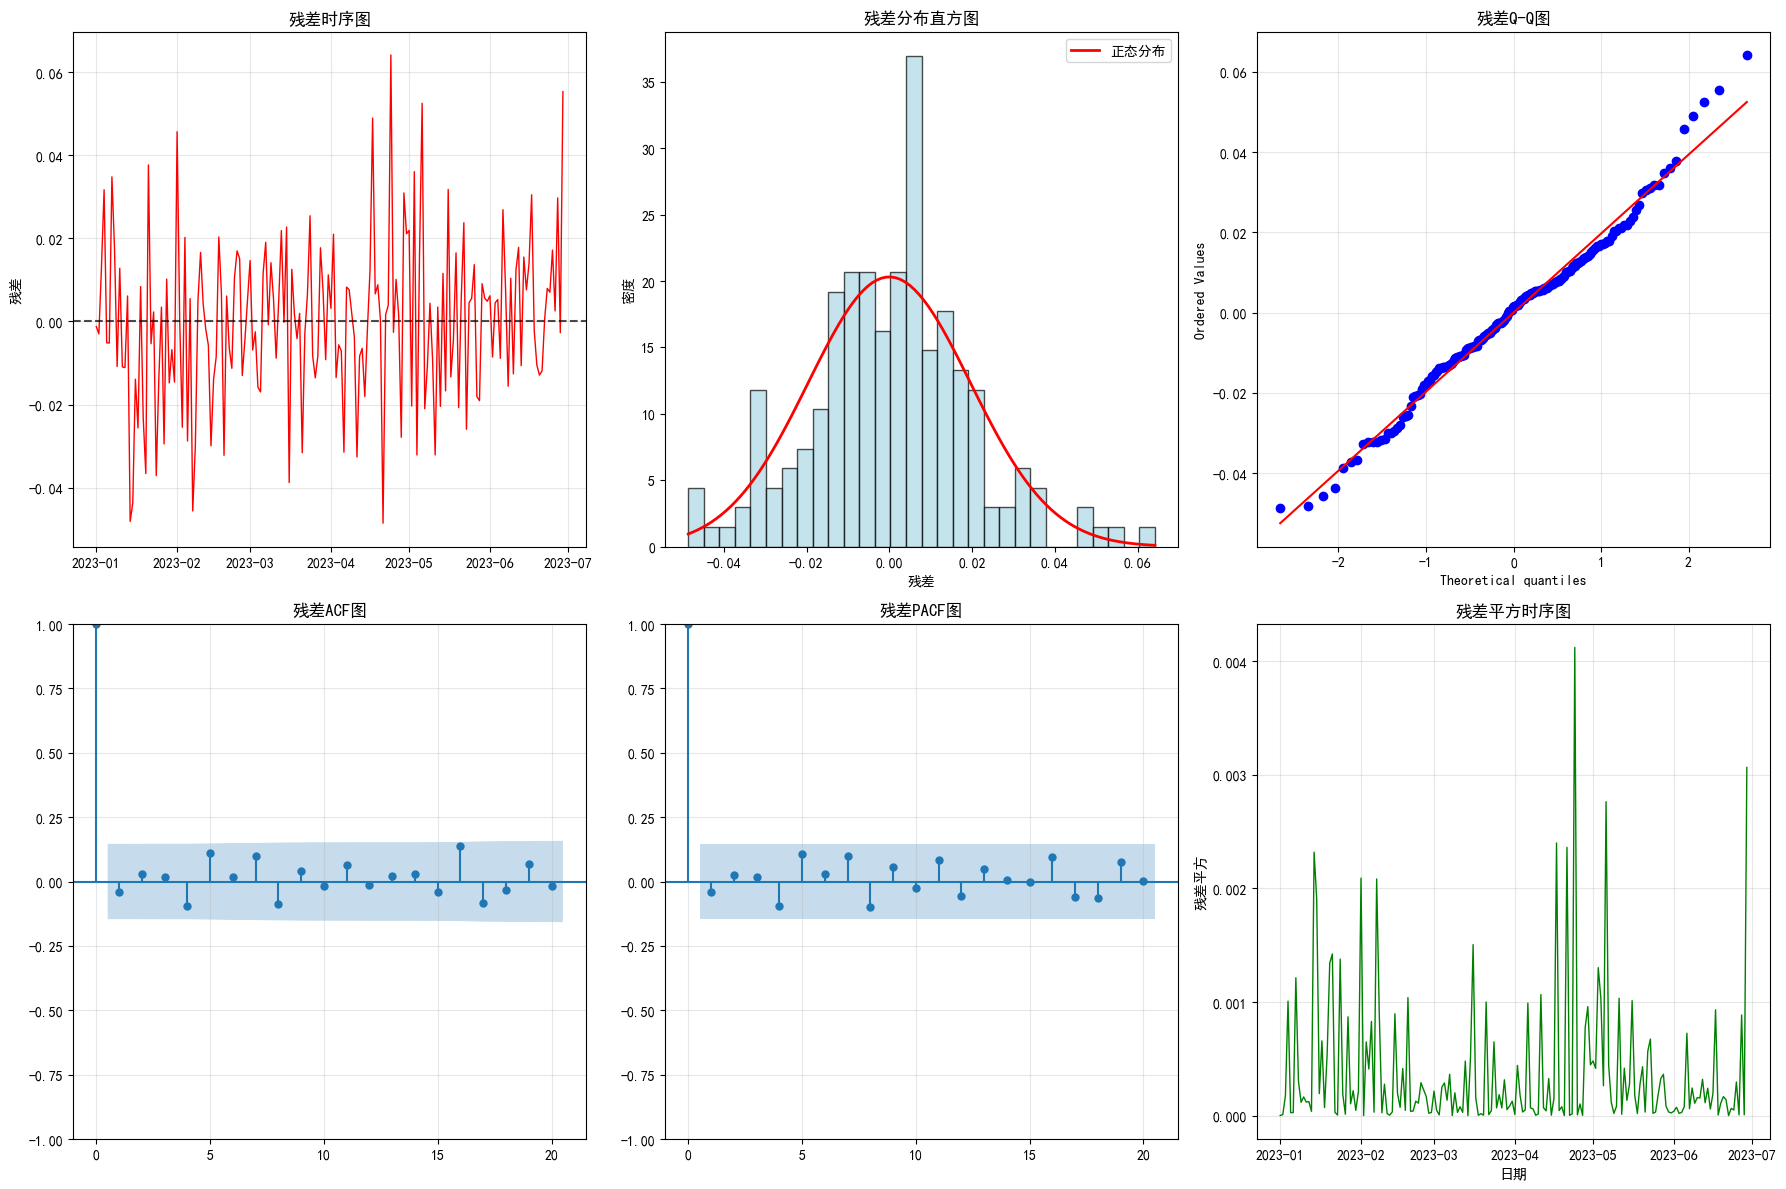


Ljung-Box检验结果（残差自相关性）:
     lb_stat  lb_pvalue
1   0.297044   0.585742
2   0.434301   0.804809
3   0.486322   0.921886
4   2.227143   0.694063
5   4.585703   0.468499
6   4.632858   0.591687
7   6.424527   0.491143
8   7.872154   0.446057
9   8.221564   0.511981
10  8.287108   0.600815
结论: 残差不存在显著自相关性（模型充分）

Jarque-Bera正态性检验:
统计量: 3.9336
p值: 0.139906
结论: 残差服从正态分布


In [9]:
print("\n7. 模型诊断")
print("-" * 30)

# 获取残差
residuals = fitted_model.resid

# 残差基本统计
print("残差统计信息:")
print(f"残差均值: {residuals.mean():.8f}")
print(f"残差标准差: {residuals.std():.6f}")
print(f"残差偏度: {residuals.skew():.3f}")
print(f"残差峰度: {residuals.kurtosis():.3f}")

# 残差诊断图
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 残差时序图
axes[0,0].plot(residuals.index, residuals, color='red', linewidth=1)
axes[0,0].axhline(y=0, color='black', linestyle='--', alpha=0.7)
axes[0,0].set_title('残差时序图', fontsize=12, fontweight='bold')
axes[0,0].set_ylabel('残差')
axes[0,0].grid(True, alpha=0.3)

# 残差直方图
axes[0,1].hist(residuals, bins=30, color='lightblue', alpha=0.7, edgecolor='black', density=True)
# 叠加正态分布曲线
x = np.linspace(residuals.min(), residuals.max(), 100)
normal_curve = (1/np.sqrt(2*np.pi*residuals.var())) * np.exp(-0.5*((x-residuals.mean())/residuals.std())**2)
axes[0,1].plot(x, normal_curve, 'r-', linewidth=2, label='正态分布')
axes[0,1].set_title('残差分布直方图', fontsize=12, fontweight='bold')
axes[0,1].set_xlabel('残差')
axes[0,1].set_ylabel('密度')
axes[0,1].legend()

# 残差Q-Q图
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[0,2])
axes[0,2].set_title('残差Q-Q图', fontsize=12, fontweight='bold')
axes[0,2].grid(True, alpha=0.3)

# 残差ACF图
plot_acf(residuals, ax=axes[1,0], lags=20, title='残差ACF图')
axes[1,0].grid(True, alpha=0.3)

# 残差PACF图
plot_pacf(residuals, ax=axes[1,1], lags=20, title='残差PACF图')
axes[1,1].grid(True, alpha=0.3)

# 残差平方的时序图（检验异方差性）
axes[1,2].plot(residuals.index, residuals**2, color='green', linewidth=1)
axes[1,2].set_title('残差平方时序图', fontsize=12, fontweight='bold')
axes[1,2].set_ylabel('残差平方')
axes[1,2].set_xlabel('日期')
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Ljung-Box检验（残差自相关性检验）
lb_test = acorr_ljungbox(residuals, lags=10, return_df=True)
print("\nLjung-Box检验结果（残差自相关性）:")
print(lb_test)

if all(lb_test['lb_pvalue'] > 0.05):
    print("结论: 残差不存在显著自相关性（模型充分）")
else:
    print("结论: 残差存在自相关性（模型可能不充分）")

# Jarque-Bera正态性检验
from scipy.stats import jarque_bera
jb_stat, jb_pvalue = jarque_bera(residuals)
print(f"\nJarque-Bera正态性检验:")
print(f"统计量: {jb_stat:.4f}")
print(f"p值: {jb_pvalue:.6f}")

if jb_pvalue > 0.05:
    print("结论: 残差服从正态分布")
else:
    print("结论: 残差不服从正态分布")

# ==========================================
# 第八步：模型预测
# ==========================================


8. 模型预测
------------------------------


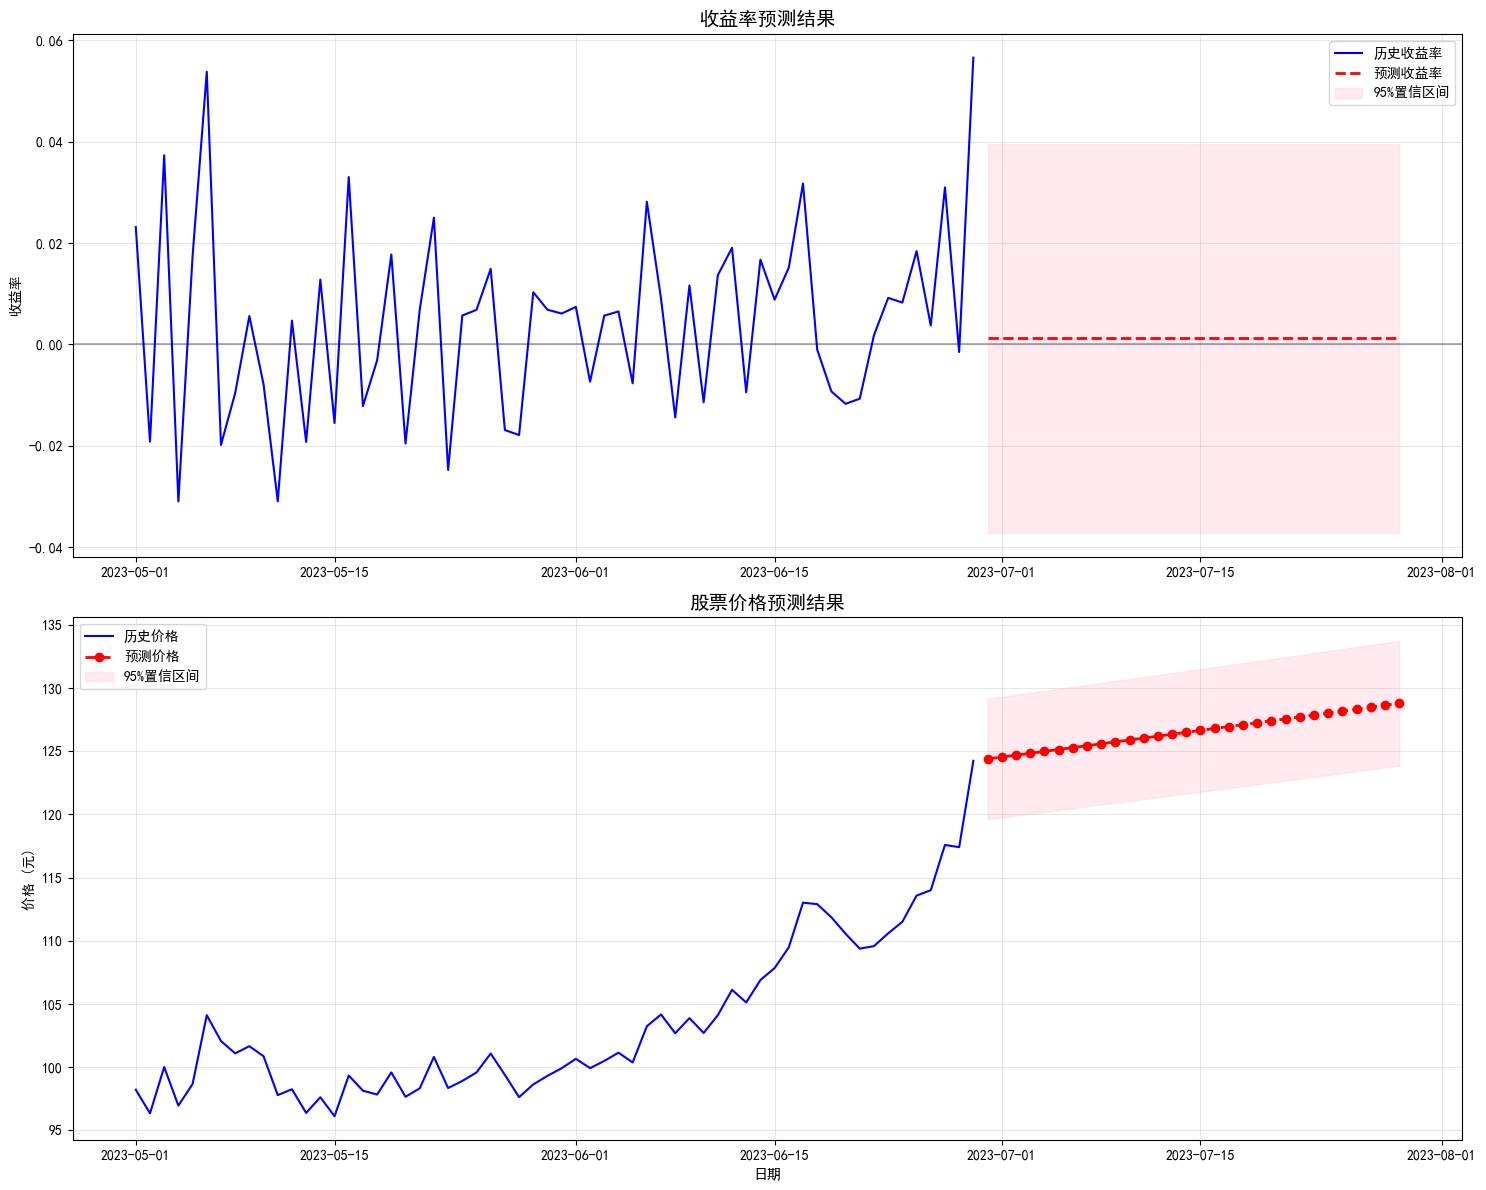

未来10天预测结果:
                   日期   预测收益率   收益率下限   收益率上限      预测价格      价格下限      价格上限
2023-06-30 2023-06-30  0.0012 -0.0372  0.0396  124.3915  119.6240  129.1591
2023-07-01 2023-07-01  0.0012 -0.0372  0.0396  124.5409  119.7676  129.3142
2023-07-02 2023-07-02  0.0012 -0.0372  0.0396  124.6905  119.9115  129.4695
2023-07-03 2023-07-03  0.0012 -0.0372  0.0396  124.8403  120.0555  129.6250
2023-07-04 2023-07-04  0.0012 -0.0372  0.0396  124.9902  120.1997  129.7807
2023-07-05 2023-07-05  0.0012 -0.0372  0.0396  125.1403  120.3440  129.9365
2023-07-06 2023-07-06  0.0012 -0.0372  0.0396  125.2906  120.4886  130.0926
2023-07-07 2023-07-07  0.0012 -0.0372  0.0396  125.4410  120.6333  130.2488
2023-07-08 2023-07-08  0.0012 -0.0372  0.0396  125.5917  120.7781  130.4052
2023-07-09 2023-07-09  0.0012 -0.0372  0.0396  125.7425  120.9232  130.5619


In [10]:
print("\n8. 模型预测")
print("-" * 30)

# 预测未来30天的收益率
forecast_steps = 30
forecast = fitted_model.forecast(steps=forecast_steps)
forecast_ci = fitted_model.get_forecast(steps=forecast_steps).conf_int()

# 创建预测日期
last_date = stock_data.index[-1]
forecast_dates = pd.date_range(start=last_date + timedelta(days=1), 
                              periods=forecast_steps, freq='D')

# 将收益率预测转换为价格预测
last_price = stock_data['price'].iloc[-1]
predicted_prices = [last_price]

for return_forecast in forecast:
    next_price = predicted_prices[-1] * (1 + return_forecast)
    predicted_prices.append(next_price)

predicted_prices = predicted_prices[1:]  # 移除初始价格

# 计算价格预测的置信区间
price_ci_lower = []
price_ci_upper = []
current_price = last_price

for i in range(forecast_steps):
    lower_return = forecast_ci.iloc[i, 0]
    upper_return = forecast_ci.iloc[i, 1]
    
    # 简化的置信区间计算（实际应该考虑累积效应）
    lower_price = current_price * (1 + lower_return)
    upper_price = current_price * (1 + upper_return)
    
    price_ci_lower.append(lower_price)
    price_ci_upper.append(upper_price)
    
    current_price = predicted_prices[i]  # 更新当前价格

# 预测结果可视化
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# 收益率预测
axes[0].plot(stock_data.index[-60:], stock_data['returns'][-60:], 
            label='历史收益率', color='blue', linewidth=1.5)
axes[0].plot(forecast_dates, forecast, 
            label='预测收益率', color='red', linestyle='--', linewidth=2)
axes[0].fill_between(forecast_dates, 
                    forecast_ci.iloc[:, 0], 
                    forecast_ci.iloc[:, 1],
                    color='pink', alpha=0.3, label='95%置信区间')
axes[0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[0].set_title('收益率预测结果', fontsize=14, fontweight='bold')
axes[0].set_ylabel('收益率')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 价格预测
axes[1].plot(stock_data.index[-60:], stock_data['price'][-60:], 
            label='历史价格', color='blue', linewidth=1.5)
axes[1].plot(forecast_dates, predicted_prices,
            label='预测价格', color='red', linestyle='--', linewidth=2, marker='o')
axes[1].fill_between(forecast_dates, price_ci_lower, price_ci_upper,
                    color='pink', alpha=0.3, label='95%置信区间')
axes[1].set_title('股票价格预测结果', fontsize=14, fontweight='bold')
axes[1].set_ylabel('价格 (元)')
axes[1].set_xlabel('日期')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 预测结果表格
forecast_df = pd.DataFrame({
    '日期': forecast_dates,
    '预测收益率': forecast,
    '收益率下限': forecast_ci.iloc[:, 0],
    '收益率上限': forecast_ci.iloc[:, 1],
    '预测价格': predicted_prices,
    '价格下限': price_ci_lower,
    '价格上限': price_ci_upper
})

print("未来10天预测结果:")
print(forecast_df.head(10).round(4))

# ==========================================
# 第九步：模型评估
# ==========================================


9. 模型评估
------------------------------
训练集大小: 144
测试集大小: 36

收益率预测精度评估:
MAE (平均绝对误差): 0.012986
RMSE (均方根误差): 0.016603
MAPE (平均绝对百分比误差): 100.07%
方向预测准确率: 33.33%


E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


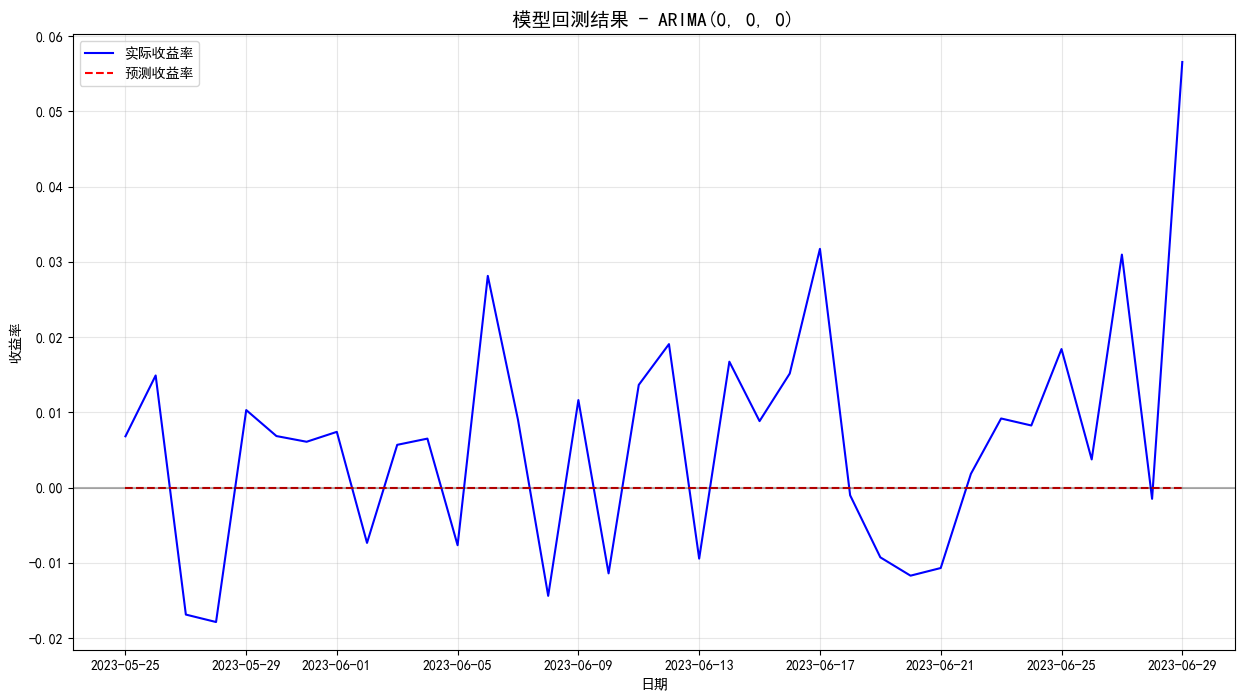

In [11]:
print("\n9. 模型评估")
print("-" * 30)

# 分割数据进行回测评估
split_ratio = 0.8
split_point = int(len(stock_data) * split_ratio)
train_data = stock_data['returns'][:split_point]
test_data = stock_data['returns'][split_point:]

print(f"训练集大小: {len(train_data)}")
print(f"测试集大小: {len(test_data)}")

# 重新训练模型
train_model = ARIMA(train_data, order=best_params)
train_fitted = train_model.fit()

# 预测测试期
test_forecast = train_fitted.forecast(steps=len(test_data))

# 计算评估指标
mae = mean_absolute_error(test_data, test_forecast)
rmse = np.sqrt(mean_squared_error(test_data, test_forecast))
mape = np.mean(np.abs((test_data - test_forecast) / test_data)) * 100

print(f"\n收益率预测精度评估:")
print(f"MAE (平均绝对误差): {mae:.6f}")
print(f"RMSE (均方根误差): {rmse:.6f}")
print(f"MAPE (平均绝对百分比误差): {mape:.2f}%")

# 方向准确率（预测涨跌方向的准确率）
actual_direction = np.sign(test_data)
predicted_direction = np.sign(test_forecast)
direction_accuracy = np.mean(actual_direction == predicted_direction)
print(f"方向预测准确率: {direction_accuracy:.2%}")

# 可视化回测结果
plt.figure(figsize=(15, 8))
plt.plot(test_data.index, test_data, label='实际收益率', color='blue', linewidth=1.5)
plt.plot(test_data.index, test_forecast, label='预测收益率', color='red', linestyle='--', linewidth=1.5)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.title(f'模型回测结果 - ARIMA{best_params}', fontsize=14, fontweight='bold')
plt.xlabel('日期')
plt.ylabel('收益率')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ==========================================
# 第十步：结果总结与投资建议
# ==========================================


10. 结果总结与投资建议
------------------------------
最优ARIMA模型: ARIMA(0, 0, 0)
模型AIC值: -901.10
模型BIC值: -894.71

预测总结（未来30天）:
平均日收益率预期: 0.0012 (0.12%)
预测波动率: 0.0000
期末价格预期: 128.80 元
总收益率预期: 3.67%
年化收益率预期: 30.26%

风险评估:
日VaR (95%): 0.0012 (0.12%)
最大预期损失 (30天): 0.15 元

投资建议: 买入
建议理由: 模型预测未来收益为正，建议适量买入
风险提示: 模型基于历史数据，实际结果可能存在差异，请谨慎投资

模型性能总结:
model_type: ARIMA(0, 0, 0)
model_aic: -901.1000
model_bic: -894.7141
mae: 0.0130
rmse: 0.0166
mape: 100.0668
direction_accuracy: 0.3333
expected_return_30d: 3.6663
recommendation: 买入

                    案例一分析完成！

附录：额外分析
------------------------------
执行滚动预测分析...


E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\

滚动预测MAE: 0.015439
滚动预测RMSE: 0.020085


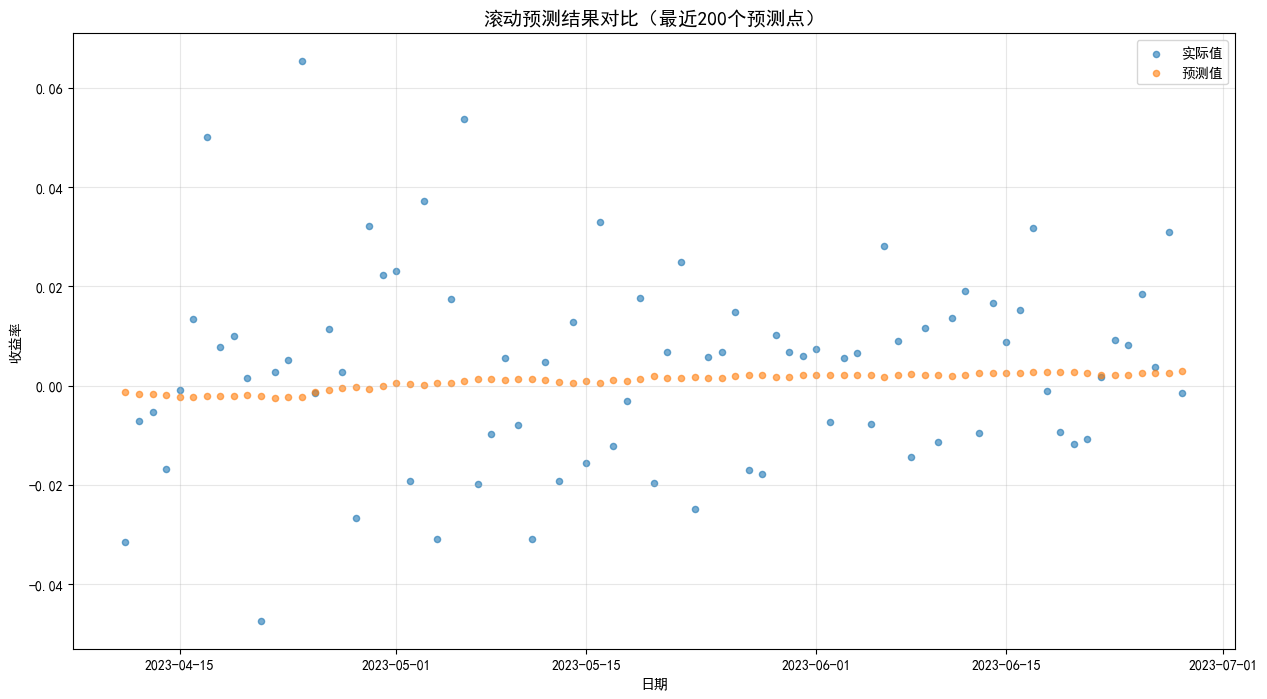


模型稳定性分析:


E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\Users\Lenovo\AppData\Local\Programs\Python\Python311\

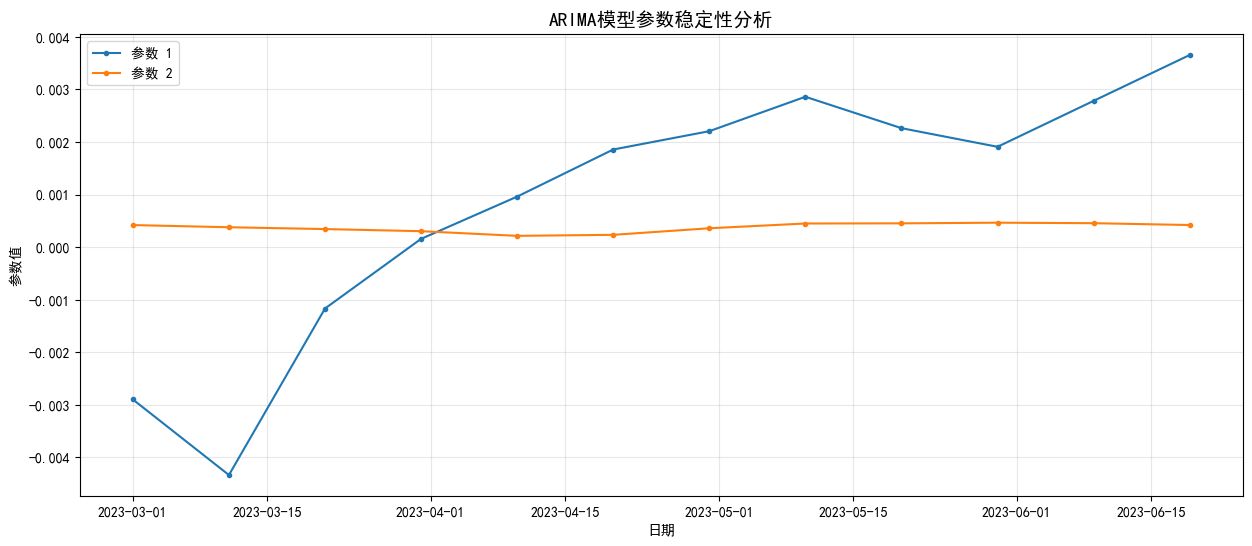

参数变异系数:
参数 1: 2.897
参数 2: 0.231

情景分析:
未来30天累积收益预期:
乐观情景: 3.67% (最终价格: 128.80元)
基准情景: 3.67% (最终价格: 128.80元)
悲观情景: 3.67% (最终价格: 128.80元)

        股票价格预测案例 - 完整分析结束


In [12]:
print("\n10. 结果总结与投资建议")
print("-" * 30)

# 模型总结
print(f"最优ARIMA模型: ARIMA{best_params}")
print(f"模型AIC值: {fitted_model.aic:.2f}")
print(f"模型BIC值: {fitted_model.bic:.2f}")

# 预测总结
avg_predicted_return = forecast.mean()
predicted_volatility = forecast.std()
price_change_expected = (predicted_prices[-1] / last_price - 1) * 100

print(f"\n预测总结（未来30天）:")
print(f"平均日收益率预期: {avg_predicted_return:.4f} ({avg_predicted_return*100:.2f}%)")
print(f"预测波动率: {predicted_volatility:.4f}")
print(f"期末价格预期: {predicted_prices[-1]:.2f} 元")
print(f"总收益率预期: {price_change_expected:.2f}%")
print(f"年化收益率预期: {avg_predicted_return * 252 * 100:.2f}%")

# 风险评估
var_95 = np.percentile(forecast, 5)  # 95% VaR
print(f"\n风险评估:")
print(f"日VaR (95%): {var_95:.4f} ({var_95*100:.2f}%)")
print(f"最大预期损失 (30天): {(last_price * (1 + var_95) - last_price):.2f} 元")

# 投资建议
if avg_predicted_return > 0.001:  # 日收益率大于0.1%
    recommendation = "买入"
    reason = "模型预测未来收益为正，建议适量买入"
elif avg_predicted_return < -0.001:  # 日收益率小于-0.1%
    recommendation = "卖出"
    reason = "模型预测未来收益为负，建议适量卖出"
else:
    recommendation = "持有"
    reason = "模型预测未来收益接近零，建议持有观望"

print(f"\n投资建议: {recommendation}")
print(f"建议理由: {reason}")
print(f"风险提示: 模型基于历史数据，实际结果可能存在差异，请谨慎投资")

# 保存结果
results_summary = {
    'model_type': f'ARIMA{best_params}',
    'model_aic': fitted_model.aic,
    'model_bic': fitted_model.bic,
    'mae': mae,
    'rmse': rmse,
    'mape': mape,
    'direction_accuracy': direction_accuracy,
    'expected_return_30d': price_change_expected,
    'recommendation': recommendation
}

print(f"\n模型性能总结:")
for key, value in results_summary.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

print("\n" + "="*60)
print("                    案例一分析完成！")
print("="*60)

# ==========================================
# 附录：额外分析和可视化
# ==========================================

print("\n附录：额外分析")
print("-" * 30)

# 1. 滚动预测分析
def rolling_forecast_analysis(data, model_order, window_size=120, forecast_horizon=5):
    """
    滚动窗口预测分析
    """
    predictions = []
    actuals = []
    forecast_dates = []
    
    for i in range(window_size, len(data) - forecast_horizon):
        # 训练数据
        train_window = data.iloc[i-window_size:i]
        
        # 实际值
        actual_values = data.iloc[i:i+forecast_horizon]
        
        try:
            # 拟合模型
            model = ARIMA(train_window, order=model_order)
            fitted = model.fit()
            
            # 预测
            forecast = fitted.forecast(steps=forecast_horizon)
            
            predictions.extend(forecast)
            actuals.extend(actual_values)
            forecast_dates.extend(actual_values.index)
            
        except:
            continue
    
    return np.array(predictions), np.array(actuals), forecast_dates

print("执行滚动预测分析...")
roll_pred, roll_actual, roll_dates = rolling_forecast_analysis(
    stock_data['returns'].dropna(), best_params, window_size=100, forecast_horizon=1
)

if len(roll_pred) > 0:
    # 滚动预测精度
    roll_mae = mean_absolute_error(roll_actual, roll_pred)
    roll_rmse = np.sqrt(mean_squared_error(roll_actual, roll_pred))
    
    print(f"滚动预测MAE: {roll_mae:.6f}")
    print(f"滚动预测RMSE: {roll_rmse:.6f}")
    
    # 可视化滚动预测结果
    plt.figure(figsize=(15, 8))
    plt.scatter(roll_dates[-200:], roll_actual[-200:], alpha=0.6, label='实际值', s=20)
    plt.scatter(roll_dates[-200:], roll_pred[-200:], alpha=0.6, label='预测值', s=20)
    plt.title('滚动预测结果对比（最近200个预测点）', fontsize=14, fontweight='bold')
    plt.xlabel('日期')
    plt.ylabel('收益率')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# 2. 模型稳定性分析
print("\n模型稳定性分析:")
param_history = []
window_size = 60

for i in range(window_size, len(stock_data['returns'].dropna()), 10):  # 每10天重新估计一次
    try:
        subset_data = stock_data['returns'].dropna().iloc[i-window_size:i]
        temp_model = ARIMA(subset_data, order=best_params)
        temp_fitted = temp_model.fit()
        param_history.append({
            'date': subset_data.index[-1],
            'params': temp_fitted.params.values
        })
    except:
        continue

if param_history:
    # 参数稳定性可视化
    param_df = pd.DataFrame([p['params'] for p in param_history])
    dates = [p['date'] for p in param_history]
    
    plt.figure(figsize=(15, 6))
    for i, col in enumerate(param_df.columns):
        plt.plot(dates, param_df.iloc[:, i], label=f'参数 {i+1}', marker='o', markersize=3)
    
    plt.title('ARIMA模型参数稳定性分析', fontsize=14, fontweight='bold')
    plt.xlabel('日期')
    plt.ylabel('参数值')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"参数变异系数:")
    for i, col in enumerate(param_df.columns):
        cv = param_df.iloc[:, i].std() / abs(param_df.iloc[:, i].mean())
        print(f"参数 {i+1}: {cv:.3f}")

# 3. 情景分析
print("\n情景分析:")
scenarios = {
    '乐观情景': np.percentile(forecast, 75),
    '基准情景': np.median(forecast),
    '悲观情景': np.percentile(forecast, 25)
}

print("未来30天累积收益预期:")
for scenario, return_rate in scenarios.items():
    cumulative_return = ((1 + return_rate) ** 30 - 1) * 100
    final_price = last_price * (1 + return_rate) ** 30
    print(f"{scenario}: {cumulative_return:.2f}% (最终价格: {final_price:.2f}元)")

print("\n" + "="*60)
print("        股票价格预测案例 - 完整分析结束")
print("="*60)